# Metrics Correlation Analysis: GCM-RCM Error Metrics

**Objective**: Analyze correlations between error metrics computed for climate model (GCM-RCM) pairs.

**Data Structure**: For each combination of `(region, gridpoint, physical_variable, model)`, we have multiple error metrics (ACC, d, KGE, etc.). We compute correlations between these metrics to identify redundancy and orthogonal error facets.

**Output**: Scatter plot matrix (pairplot), correlation heatmaps, and statistical summaries.


## 1. Project Setup & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.width', 300)
pd.set_option('display.max_columns', None)

import os
OUTPUT_DIR = "./output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
# Available regions. Set to None or empty list to include ALL regions. Analyze only France region: ['FR']
REGIONS = None

# Physical variables: 'ppt' (precipitation) or 'tas' (temperature). Set to None to include both. Only precipitation: ['ppt']
PHYSICAL_VARIABLES = ['ppt']

# Metric abbreviations to include in the correlation analysis. None = all metrics; or specify like ['ACC', 'd', 'KGE (2009)', 'BM']
METRIC_ABBREVIATIONS = ['H10 (MAHE)', 'd', 'dr', 'NED', 'MV', 'KGE (2009)']

# Correlation method: 'pearson', 'spearman', or 'kendall'
CORRELATION_METHOD = 'pearson'

print(f"Regions: {REGIONS if REGIONS else 'ALL'}")
print(f"Physical Variables: {PHYSICAL_VARIABLES if PHYSICAL_VARIABLES else 'ALL'}")
print(f"Metric Abbreviations: {METRIC_ABBREVIATIONS if METRIC_ABBREVIATIONS else 'ALL'}")
print(f"Correlation Method: {CORRELATION_METHOD}")


Regions: ALL
Physical Variables: ['ppt']
Metric Abbreviations: ['H10 (MAHE)', 'd', 'dr', 'NED', 'MV', 'KGE (2009)']
Correlation Method: pearson


## 2. Load Data from Database

We'll query the error and metrics tables from the database (as described in the SQL schema).

In [3]:
import sys
sys.path.append('..') 
from utils import get_db_connection
engine = get_db_connection()
conn = engine.connect()


In [4]:
where_clauses = []

if REGIONS is not None and len(REGIONS) > 0:
    regions_str = "', '".join(REGIONS)
    where_clauses.append(f"error.region IN ('{regions_str}')")

if PHYSICAL_VARIABLES is not None and len(PHYSICAL_VARIABLES) > 0:
    vars_str = "', '".join(PHYSICAL_VARIABLES)
    where_clauses.append(f"error.physical_variable IN ('{vars_str}')")

if METRIC_ABBREVIATIONS is not None and len(METRIC_ABBREVIATIONS) > 0:
    metrics_str = "', '".join(METRIC_ABBREVIATIONS)
    where_clauses.append(f"metrics.metric_name IN ('{metrics_str}')")

where_clause = " AND ".join(where_clauses)
if where_clause:
    where_clause = f"WHERE {where_clause}"

query = f"""
SELECT 
    error.region,
    error.gridpoint,
    error.physical_variable,
    error.model,
    error.rcm_id,
    error.gcm_id,
    error.metric_id,
    metrics.metric_name,
    error.mat_vector
FROM 
    error 
LEFT JOIN 
    metrics ON metrics.id = error.metric_id
{where_clause}
"""

df_raw = pd.read_sql_query(query, conn)
print(f"✓ Data loaded: {len(df_raw)} rows")
print(f"  Columns: {list(df_raw.columns)}")
print(f"\nFirst few rows:")
print(df_raw.head(5))


✓ Data loaded: 5584572 rows
  Columns: ['region', 'gridpoint', 'physical_variable', 'model', 'rcm_id', 'gcm_id', 'metric_id', 'metric_name', 'mat_vector']

First few rows:
  region  gridpoint physical_variable  model  rcm_id  gcm_id  metric_id metric_name  mat_vector
0     FR          2               ppt     18       1       3         95          dr    0.354677
1     FR          2               ppt     19       2       3         95          dr    0.343277
2     FR          2               ppt     40       6       4         95          dr    0.351538
3     FR          2               ppt     35       2       3         95          dr    0.383483
4     FR          2               ppt     46      11       5         95          dr    0.293005


## 3. Data Filtering & Preprocessing

Apply the filters to select the region(s), physical variable(s), and metric(s) of interest.

In [5]:
df = df_raw.copy()

print(f"✓ Data retrieved (pre-filtered by database query):")
print(f"  Total rows: {len(df)}")
print(f"  Regions: {sorted(df['region'].unique())}")
print(f"  Physical variables: {sorted(df['physical_variable'].unique())}")
print(f"  Unique metrics: {df['metric_name'].nunique()}")

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nDataset shape: {df.shape}")
print(f"Metrics: {sorted(df['metric_name'].unique())}")
print(f"Unique models: {df['model'].nunique()}")
print(f"Unique gridpoints: {df['gridpoint'].nunique()}")


✓ Data retrieved (pre-filtered by database query):
  Total rows: 5584572
  Regions: ['AL', 'BI', 'EA', 'FR', 'IP', 'MD', 'ME', 'SC']
  Regions: ['AL', 'BI', 'EA', 'FR', 'IP', 'MD', 'ME', 'SC']
  Physical variables: ['ppt']
  Physical variables: ['ppt']
  Unique metrics: 6

Missing values:
  Unique metrics: 6

Missing values:
region               0
gridpoint            0
physical_variable    0
model                0
rcm_id               0
gcm_id               0
metric_id            0
metric_name          0
mat_vector           0
dtype: int64

Dataset shape: (5584572, 9)
region               0
gridpoint            0
physical_variable    0
model                0
rcm_id               0
gcm_id               0
metric_id            0
metric_name          0
mat_vector           0
dtype: int64

Dataset shape: (5584572, 9)
Metrics: ['H10 (MAHE)', 'KGE (2009)', 'MV', 'NED', 'd', 'dr']
Unique models: 89
Metrics: ['H10 (MAHE)', 'KGE (2009)', 'MV', 'NED', 'd', 'dr']
Unique models: 89
Unique gridpoin

## 4. Create Pivot Table for Correlation Analysis

Transform the data so that each row represents a unique `(region, gridpoint, physical_variable, model)` grouping,  
and each column is a metric. This structure allows us to compute correlations between metrics.

In [6]:
# Create a grouping key for (region, gridpoint, physical_variable, model)
df['group_key'] = df.apply(
    lambda row: f"{row['region']}_{row['gridpoint']}_{row['physical_variable']}_{row['model']}", 
    axis=1
)

# Pivot: rows are group_keys, columns are metric names, values are error values
pivot_df = df.pivot_table(
    index='group_key',
    columns='metric_name',
    values='mat_vector',
    aggfunc='first'  # Should be unique per group_key, but just in case
)

print(f"✓ Pivot table created:")
print(f"  Shape: {pivot_df.shape}")
print(f"  Rows (unique group_keys): {pivot_df.shape[0]}")
print(f"  Columns (metrics): {pivot_df.shape[1]}")
print(f"\nMetrics in pivot table:")
print(pivot_df.columns.tolist())
print(f"\nFirst few rows:")
print(pivot_df.head())

print(f"\nMissing values per metric:")
print(pivot_df.isnull().sum())


✓ Pivot table created:
  Shape: (930762, 6)
  Rows (unique group_keys): 930762
  Columns (metrics): 6

Metrics in pivot table:
['H10 (MAHE)', 'KGE (2009)', 'MV', 'NED', 'd', 'dr']

First few rows:
metric_name    H10 (MAHE)  KGE (2009)        MV        NED         d        dr
group_key                                                                     
AL_100_ppt_1     1.204326   -0.034279  2.465756  21.536060  0.381105  0.372480
AL_100_ppt_10    1.015563    0.018289  1.709085  18.968383  0.407207  0.341287
AL_100_ppt_11    1.066794   -0.070078  1.909073  20.639549  0.324016  0.311824
AL_100_ppt_12    0.968289    0.056174  1.609313  18.498933  0.409246  0.344868
AL_100_ppt_13    1.121913   -0.297168  1.759285  20.004237  0.363676  0.046888

Missing values per metric:
metric_name
H10 (MAHE)    0
KGE (2009)    0
MV            0
NED           0
d             0
dr            0
dtype: int64


In [7]:
pivot_df_clean = pivot_df.dropna()

print(f"  Original: {pivot_df.shape[0]} rows")
print(f"  After dropna: {pivot_df_clean.shape[0]} rows")
print(f"  Rows removed: {pivot_df.shape[0] - pivot_df_clean.shape[0]}")


  Original: 930762 rows
  After dropna: 930762 rows
  Rows removed: 0


## 5. Compute Pairwise Correlations

Calculate correlation coefficients between all pairs of metrics.

In [8]:
corr_matrix = pivot_df_clean.corr(method=CORRELATION_METHOD)

print(f"✓ Correlation matrix computed ({CORRELATION_METHOD}):")
print(f"  Shape: {corr_matrix.shape}")
print(f"\nCorrelation Matrix:")
print(corr_matrix)

✓ Correlation matrix computed (pearson):
  Shape: (6, 6)

Correlation Matrix:
metric_name  H10 (MAHE)  KGE (2009)        MV       NED         d        dr
metric_name                                                                
H10 (MAHE)     1.000000   -0.522364  0.910520  0.872165 -0.334306 -0.367954
KGE (2009)    -0.522364    1.000000 -0.220598 -0.202502  0.667270  0.833230
MV             0.910520   -0.220598  1.000000  0.948414 -0.192735 -0.031408
NED            0.872165   -0.202502  0.948414  1.000000 -0.200280 -0.004764
d             -0.334306    0.667270 -0.192735 -0.200280  1.000000  0.631335
dr            -0.367954    0.833230 -0.031408 -0.004764  0.631335  1.000000


In [9]:
def pairwise_corr_with_pvalues(df, method='pearson'):
    """Compute pairwise correlations and p-values."""
    cols = df.columns
    n_cols = len(cols)
    results = []
    
    for i in range(n_cols):
        for j in range(i + 1, n_cols):
            metric1 = cols[i]
            metric2 = cols[j]
            
            if method == 'pearson':
                corr, pval = pearsonr(df[metric1], df[metric2])
            elif method == 'spearman':
                corr, pval = spearmanr(df[metric1], df[metric2])
            elif method == 'kendall':
                corr, pval = kendalltau(df[metric1], df[metric2])
            else:
                raise ValueError(f"Unknown method: {method}")
            
            results.append({
                'Metric 1': metric1,
                'Metric 2': metric2,
                'Correlation': corr,
                'P-value': pval,
                'N': len(df)
            })
    
    return pd.DataFrame(results)

In [10]:
pairwise_df = pairwise_corr_with_pvalues(pivot_df_clean, method=CORRELATION_METHOD)

pairwise_df['Abs_Corr'] = pairwise_df['Correlation'].abs()
pairwise_df = pairwise_df.sort_values('Abs_Corr', ascending=False).drop('Abs_Corr', axis=1)

print(f"\n✓ Pairwise correlations ({len(pairwise_df)} pairs):")
print(pairwise_df.to_string(index=False))


✓ Pairwise correlations (15 pairs):
  Metric 1   Metric 2  Correlation       P-value      N
        MV        NED     0.948414  0.000000e+00 930762
H10 (MAHE)         MV     0.910520  0.000000e+00 930762
H10 (MAHE)        NED     0.872165  0.000000e+00 930762
KGE (2009)         dr     0.833230  0.000000e+00 930762
KGE (2009)          d     0.667270  0.000000e+00 930762
         d         dr     0.631335  0.000000e+00 930762
H10 (MAHE) KGE (2009)    -0.522364  0.000000e+00 930762
H10 (MAHE)         dr    -0.367954  0.000000e+00 930762
H10 (MAHE)          d    -0.334306  0.000000e+00 930762
KGE (2009)         MV    -0.220598  0.000000e+00 930762
KGE (2009)        NED    -0.202502  0.000000e+00 930762
       NED          d    -0.200280  0.000000e+00 930762
        MV          d    -0.192735  0.000000e+00 930762
        MV         dr    -0.031408 8.749364e-202 930762
       NED         dr    -0.004764  4.301823e-06 930762


- $H_0$: zero correlation  
- $H_1$: non-zero correlation

This **p-value** is the two-sided probability of observing a correlation at least as extreme as the measured one under the null hypothesis.

Assumptions
- **Pearson**: assumes a linear relationship and (approximately) bivariate normality.  
- **Spearman** / **Kendall**: rank-based (nonparametric), less sensitive to outliers or non-normality.

Can also be seen as association:
- $H_0$: The population correlation is zero (no association)
- $H_1$: The population correlation is non-zero (association exists)

## 6. Scatter Plot Matrix (Pairplot)

Generate a pairplot to visualize relationships between metrics (similar to the attached image).

✓ Pairplot saved to: ./output/pairplot_pearson.png


<Figure size 1600x1600 with 0 Axes>

✓ Pairplot saved to: ./output/pairplot_pearson.png


<Figure size 1600x1600 with 0 Axes>

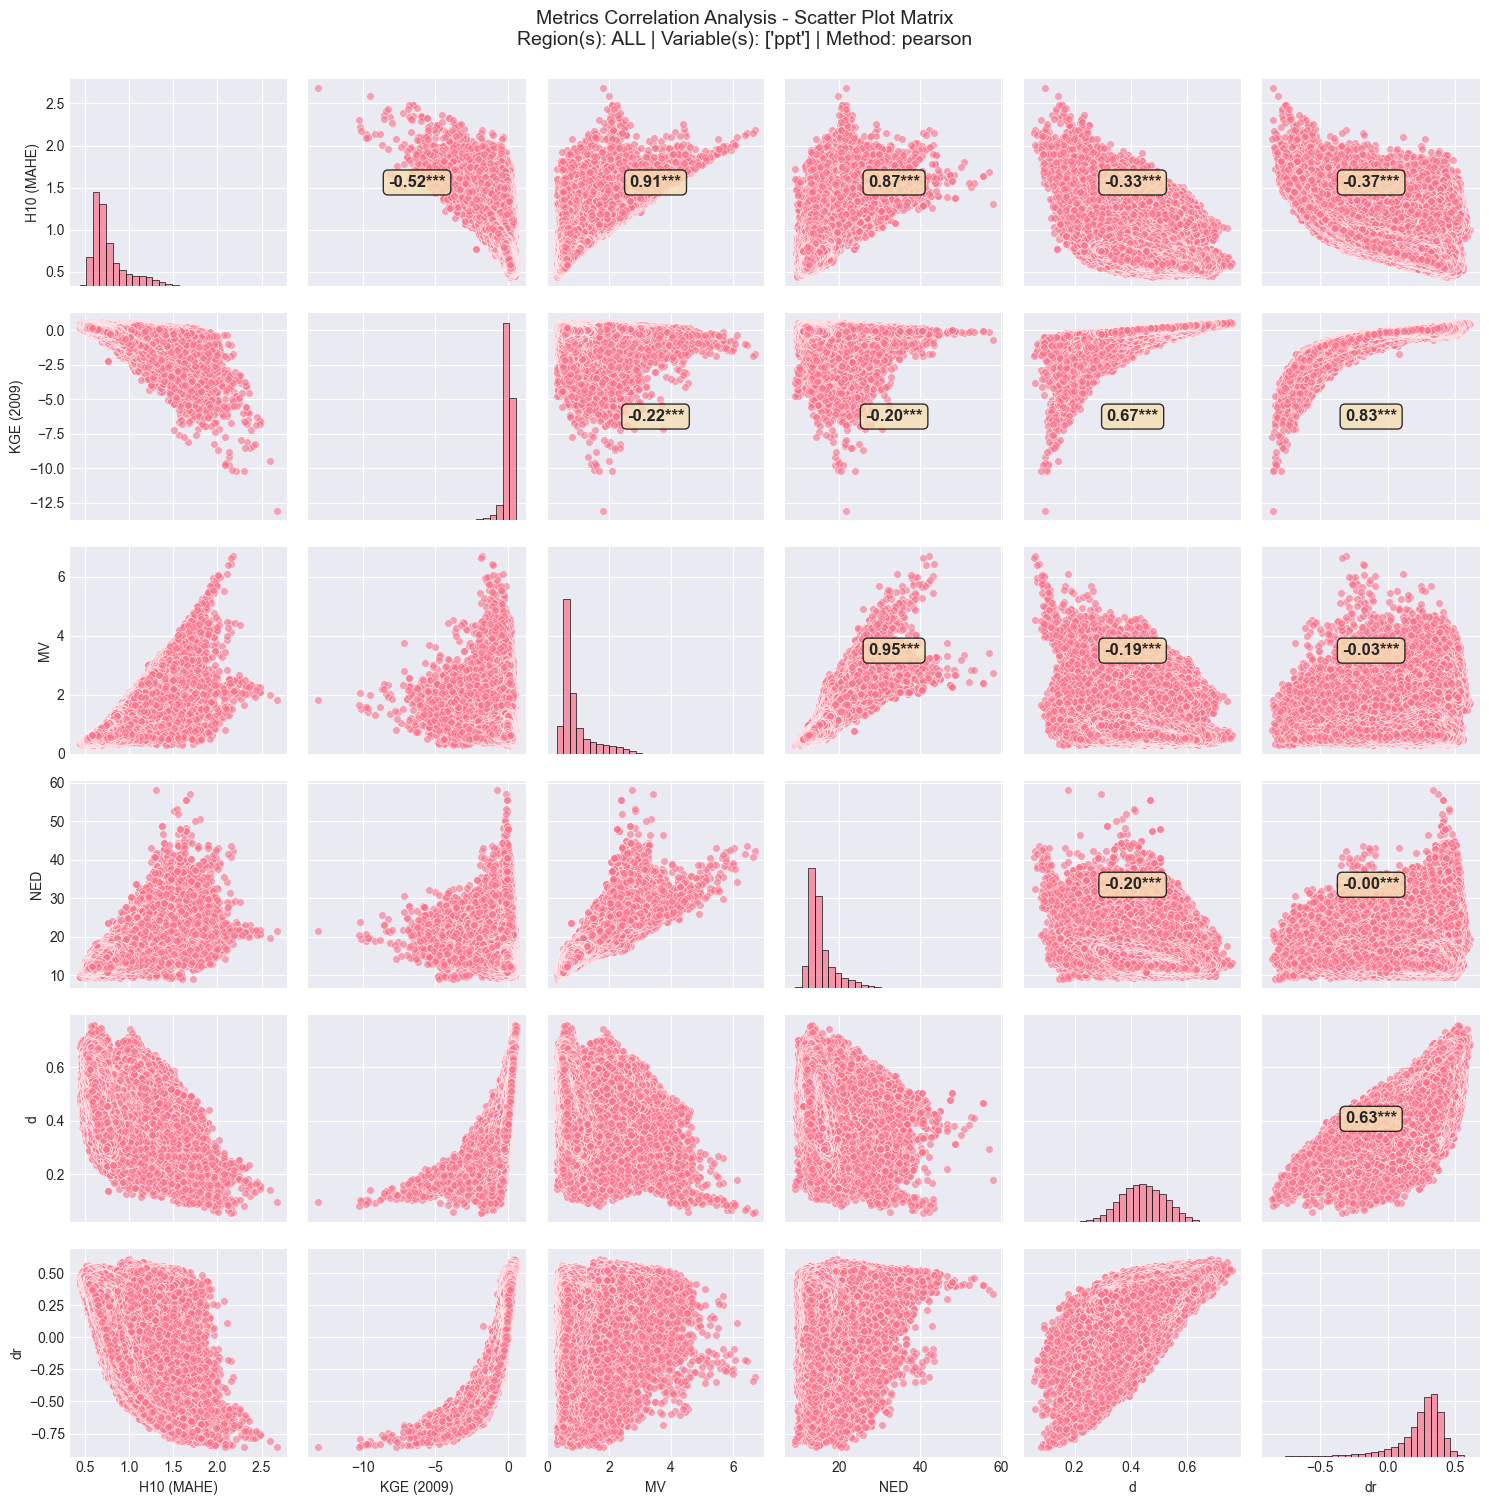

In [11]:
plt.figure(figsize=(16, 16))
g = sns.pairplot(
    pivot_df_clean,
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 30},
    diag_kws={'bins': 30, 'edgecolor': 'k', 'alpha': 0.7}
)

def add_correlation_annotations(g, corr_matrix, pairwise_df):
    """Add correlation values with p-value based significance markers to upper triangle of pairplot."""
    for i, ax_row in enumerate(g.axes):
        for j, ax in enumerate(ax_row):
            if i < j:
                col_i = g.data.columns[i]
                col_j = g.data.columns[j]
                corr_val = corr_matrix.loc[col_i, col_j]
                
                pair_row = pairwise_df[
                    ((pairwise_df['Metric 1'] == col_i) & (pairwise_df['Metric 2'] == col_j)) |
                    ((pairwise_df['Metric 1'] == col_j) & (pairwise_df['Metric 2'] == col_i))
                ]
                
                if not pair_row.empty:
                    pval = pair_row.iloc[0]['P-value']
                    sig_marker = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "ns"
                else:
                    sig_marker = "?"
                
                ax.text(
                    0.5, 0.5,
                    f'{corr_val:.2f}{sig_marker}',
                    transform=ax.transAxes,
                    ha='center', va='center',
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
                )
                ax.set_title('')

add_correlation_annotations(g, corr_matrix, pairwise_df)

plt.suptitle(
    f'Metrics Correlation Analysis - Scatter Plot Matrix\n'
    f'Region(s): {REGIONS if REGIONS else "ALL"} | '
    f'Variable(s): {PHYSICAL_VARIABLES if PHYSICAL_VARIABLES else "ALL"} | '
    f'Method: {CORRELATION_METHOD}',
    fontsize=14, y=1.00
)
plt.tight_layout()

output_file = f"{OUTPUT_DIR}/pairplot_{CORRELATION_METHOD}.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✓ Pairplot saved to: {output_file}")
plt.show()


The `**` symbols in the pairplot are significance markers that indicate the statistical significance of the correlation coefficients displayed in the upper triangle of the plot.

- `***` = p-value < 0.001 (highly significant)
- `**` = p-value < 0.01 (very significant)
- `*` = p-value < 0.05 (significant)
- ns = not significant (p-value ≥ 0.05)

## 7. Correlation Heatmap

Visualize the correlation matrix as a heatmap with hierarchical clustering.

✓ Heatmap saved to: ./output/heatmap_clustered_pearson.png


<Figure size 1200x1000 with 0 Axes>

✓ Heatmap saved to: ./output/heatmap_clustered_pearson.png


<Figure size 1200x1000 with 0 Axes>

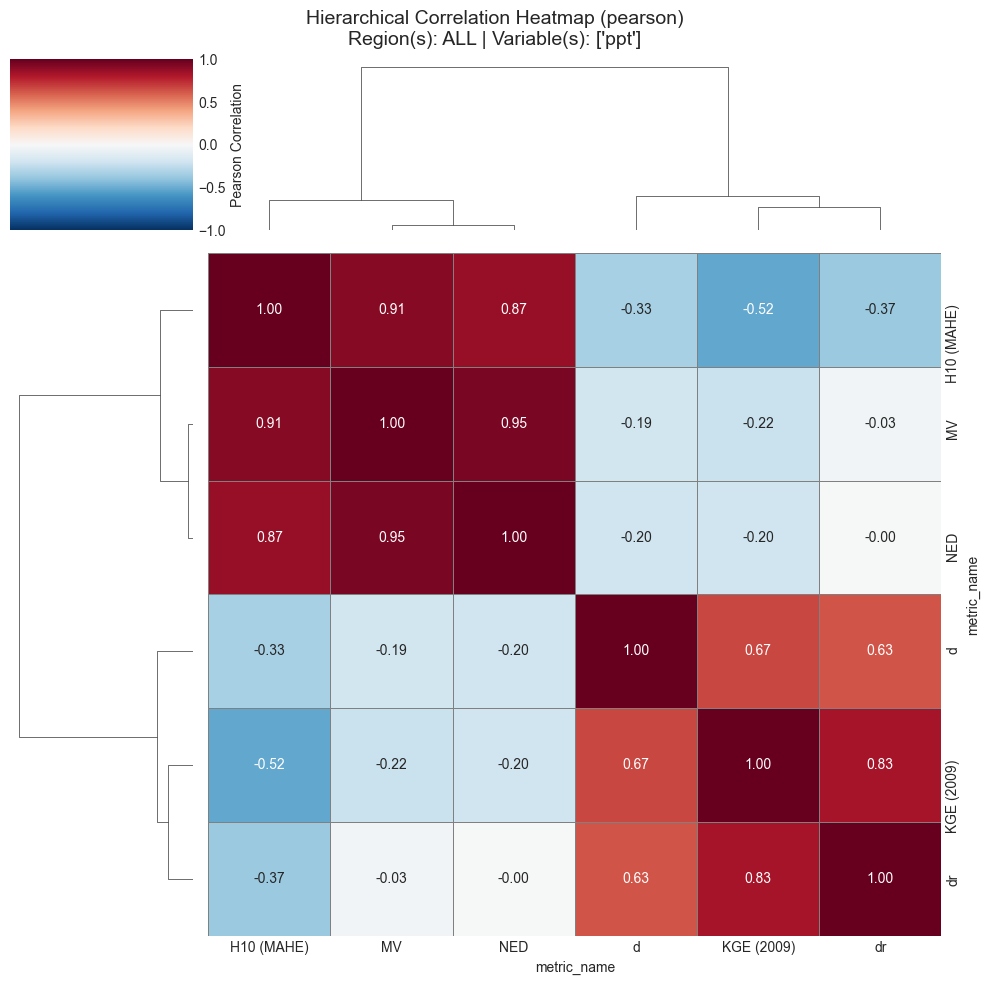

In [12]:
plt.figure(figsize=(12, 10))
sns.clustermap(
    corr_matrix,
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    cbar_kws={'label': f'{CORRELATION_METHOD.capitalize()} Correlation'},
    linewidths=0.5,
    linecolor='gray'
)

plt.suptitle(
    f'Hierarchical Correlation Heatmap ({CORRELATION_METHOD})\n'
    f'Region(s): {REGIONS if REGIONS else "ALL"} | Variable(s): {PHYSICAL_VARIABLES if PHYSICAL_VARIABLES else "ALL"}',
    fontsize=14, y=0.98
)
plt.tight_layout()

output_file = f"{OUTPUT_DIR}/heatmap_clustered_{CORRELATION_METHOD}.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✓ Heatmap saved to: {output_file}")
plt.show()


## 8. Export Results

Save correlation matrices and pairwise correlations to CSV files.

In [13]:
# Save correlation matrix to CSV
corr_matrix.to_csv(f"{OUTPUT_DIR}/correlation_matrix_{CORRELATION_METHOD}.csv")
print(f"✓ Correlation matrix saved to: {OUTPUT_DIR}/correlation_matrix_{CORRELATION_METHOD}.csv")

# Save pairwise correlations to CSV
pairwise_df.to_csv(f"{OUTPUT_DIR}/pairwise_correlations_{CORRELATION_METHOD}.csv", index=False)
print(f"✓ Pairwise correlations saved to: {OUTPUT_DIR}/pairwise_correlations_{CORRELATION_METHOD}.csv")

# Save summary statistics
summary_stats = pd.DataFrame({
    'Metric': corr_matrix.columns,
    'Mean': pivot_df_clean.mean(),
    'Std': pivot_df_clean.std(),
    'Min': pivot_df_clean.min(),
    'Max': pivot_df_clean.max(),
})
summary_stats.to_csv(f"{OUTPUT_DIR}/metrics_summary_statistics.csv", index=False)
print(f"✓ Summary statistics saved to: {OUTPUT_DIR}/metrics_summary_statistics.csv")

# Save analysis metadata
metadata = {
    'Analysis Date': pd.Timestamp.now(),
    'Correlation Method': CORRELATION_METHOD,
    'Regions': str(REGIONS),
    'Physical Variables': str(PHYSICAL_VARIABLES),
    'Metric Abbreviations': str(METRIC_ABBREVIATIONS),
    'Number of Rows': pivot_df_clean.shape[0],
    'Number of Metrics': pivot_df_clean.shape[1],
    'Metrics': ', '.join(pivot_df_clean.columns)
}

metadata_df = pd.DataFrame(list(metadata.items()), columns=['Parameter', 'Value'])
metadata_df.to_csv(f"{OUTPUT_DIR}/analysis_metadata.csv", index=False)
print(f"✓ Analysis metadata saved to: {OUTPUT_DIR}/analysis_metadata.csv")

print(f"\n✓ All results exported to: {OUTPUT_DIR}/")


✓ Correlation matrix saved to: ./output/correlation_matrix_pearson.csv
✓ Pairwise correlations saved to: ./output/pairwise_correlations_pearson.csv
✓ Summary statistics saved to: ./output/metrics_summary_statistics.csv
✓ Analysis metadata saved to: ./output/analysis_metadata.csv

✓ All results exported to: ./output/
✓ Summary statistics saved to: ./output/metrics_summary_statistics.csv
✓ Analysis metadata saved to: ./output/analysis_metadata.csv

✓ All results exported to: ./output/


## 9. Summary & Insights

Summary of the correlation analysis results.

In [14]:
print("=" * 90)
print("ANALYSIS SUMMARY")
print("=" * 90)
print(f"\nData Summary:")
print(f"  Total rows analyzed: {pivot_df_clean.shape[0]}")
print(f"  Number of metrics: {pivot_df_clean.shape[1]}")
print(f"  Correlation method: {CORRELATION_METHOD}")

print(f"\nMetrics included:")
for i, metric in enumerate(pivot_df_clean.columns, 1):
    print(f"  {i}. {metric}")

print(f"\nAll Pairwise Correlations (sorted by absolute correlation value):")
print("-" * 90)
# Create a formatted display with all correlations and p-values
display_df = pairwise_df.copy()
display_df['Significance'] = display_df['P-value'].apply(
    lambda p: "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
)
display_df = display_df[['Metric 1', 'Metric 2', 'Correlation', 'P-value', 'Significance']]
print(display_df.to_string(index=False))

print("\n" + "-" * 90)
print(f"Significance levels (α = 0.05):")
sig_count = (pairwise_df['P-value'] < 0.05).sum()
print(f"  Significant correlations: {sig_count} / {len(pairwise_df)} ({100*sig_count/len(pairwise_df):.1f}%)")

print("\nNote: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("=" * 90)


ANALYSIS SUMMARY

Data Summary:
  Total rows analyzed: 930762
  Number of metrics: 6
  Correlation method: pearson

Metrics included:
  1. H10 (MAHE)
  2. KGE (2009)
  3. MV
  4. NED
  5. d
  6. dr

All Pairwise Correlations (sorted by absolute correlation value):
------------------------------------------------------------------------------------------
  Metric 1   Metric 2  Correlation       P-value Significance
        MV        NED     0.948414  0.000000e+00          ***
H10 (MAHE)         MV     0.910520  0.000000e+00          ***
H10 (MAHE)        NED     0.872165  0.000000e+00          ***
KGE (2009)         dr     0.833230  0.000000e+00          ***
KGE (2009)          d     0.667270  0.000000e+00          ***
         d         dr     0.631335  0.000000e+00          ***
H10 (MAHE) KGE (2009)    -0.522364  0.000000e+00          ***
H10 (MAHE)         dr    -0.367954  0.000000e+00          ***
H10 (MAHE)          d    -0.334306  0.000000e+00          ***
KGE (2009)         MV   